In [2]:
!pip install xgboost
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
import math
import xgboost as xgb
import toad

     ---------------------------------------- 70.9/70.9 MB 8.0 MB/s eta 0:00:00


In [3]:
data_all=pd.read_csv("D:/从c盘转移的桌面/github/Python Financial Engineering/Financial Engineering Project5/scorecard.txt")
ex_lis=['uid','samp_type','bad_ind']
ft_lis=list(data_all.columns)
for i in ex_lis:
    ft_lis.remove(i)

In [4]:
dev=data_all[(data_all['samp_type']=='dev')]
val=data_all[(data_all['samp_type']=='val')]#val type
off=data_all[(data_all['samp_type']=='off')]#off type

In [5]:
dev_slct1,drop_lst=toad.selection.select(dev,dev['bad_ind'],empty=0.7,iv=0.03,corr=0.7,return_drop=True,exclude=ex_lis)
#dev_slct1 filtered out dev according to iv and not include ex_lis

In [6]:
combiner=toad.transform.Combiner()
combiner.fit(dev_slct1,dev_slct1['bad_ind'],method='chi',min_samples=0.05,exclude=ex_lis)
bins=combiner.export()

In [7]:
dev_slct2=combiner.transform(dev_slct1)#trainning dev_slct1 into dev_slct2
val2=combiner.transform(val[dev_slct1.columns])#keep val useful columns and trained To val2
off2=combiner.transform(off[dev_slct1.columns])

print(dev.act_info)

0        0.423077
1        0.448718
2        0.179487
3        0.423077
4        0.166667
           ...   
65299    0.076923
65300    0.076923
65301    0.076923
65302    0.076923
65303    0.076923
Name: act_info, Length: 65304, dtype: float64


<Axes: xlabel='act_info', ylabel='prop'>

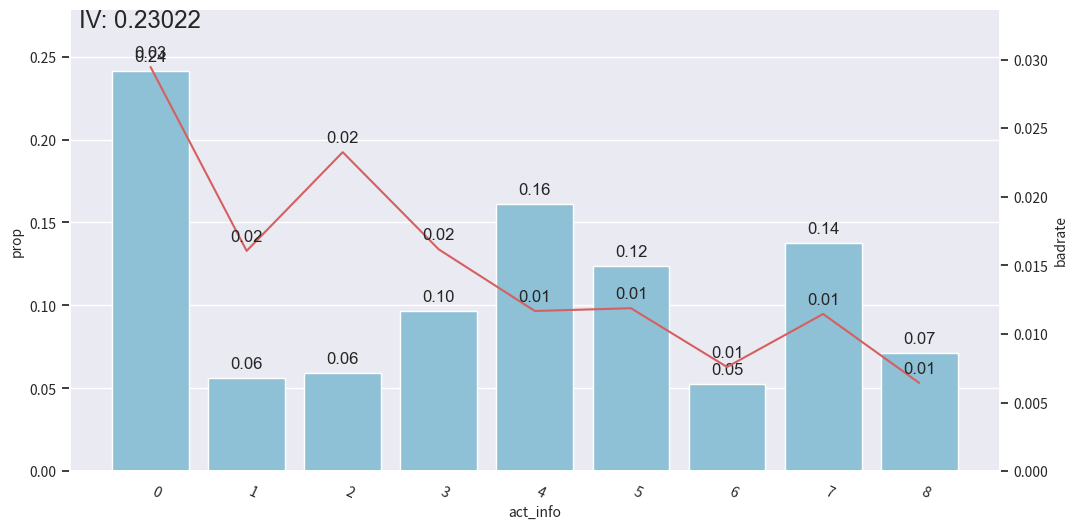

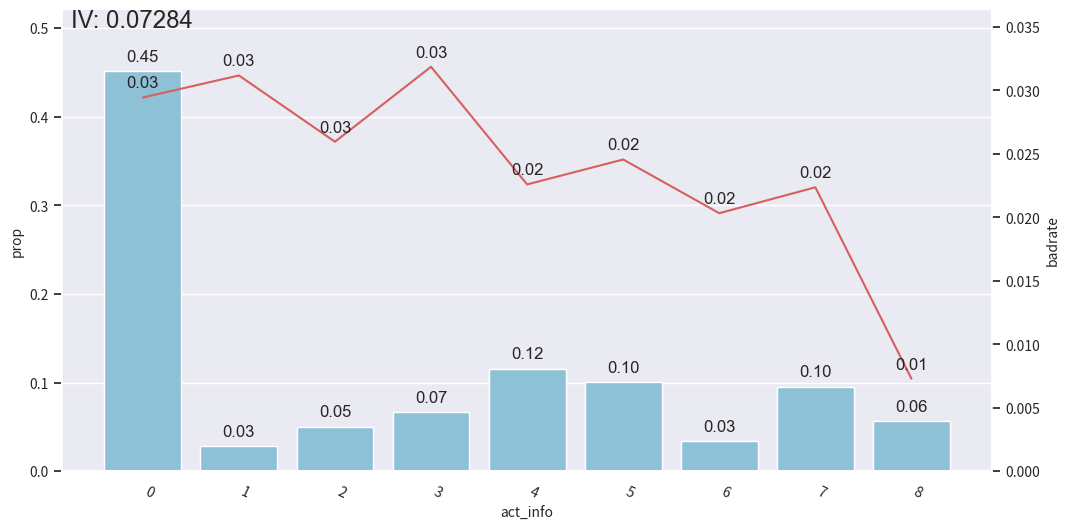

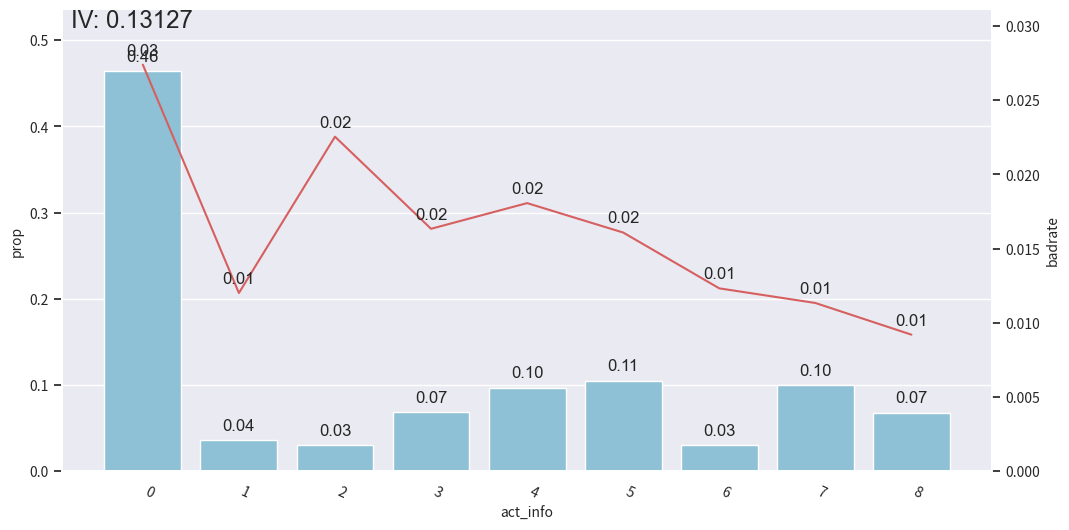

In [8]:
from toad.plot import bin_plot,badrate_plot
bin_plot(dev_slct2,x='act_info',target='bad_ind')
bin_plot(val2,x='act_info',target = 'bad_ind')
bin_plot(off2,x='act_info',target = 'bad_ind')

In [9]:
adj_bin = {'act_info':[0.16666666666666666,0.35897435897435903,]}
combiner.set_rules(adj_bin)

In [10]:
dev_slct3=combiner.transform(dev_slct1)#dev3 is created by dev1 by three bins model
val3=combiner.transform(val[dev_slct1.columns])#val3 is created by filtering useful columns through val with three bins model
off3=combiner.transform(off[dev_slct1.columns])

<Axes: xlabel='act_info', ylabel='prop'>

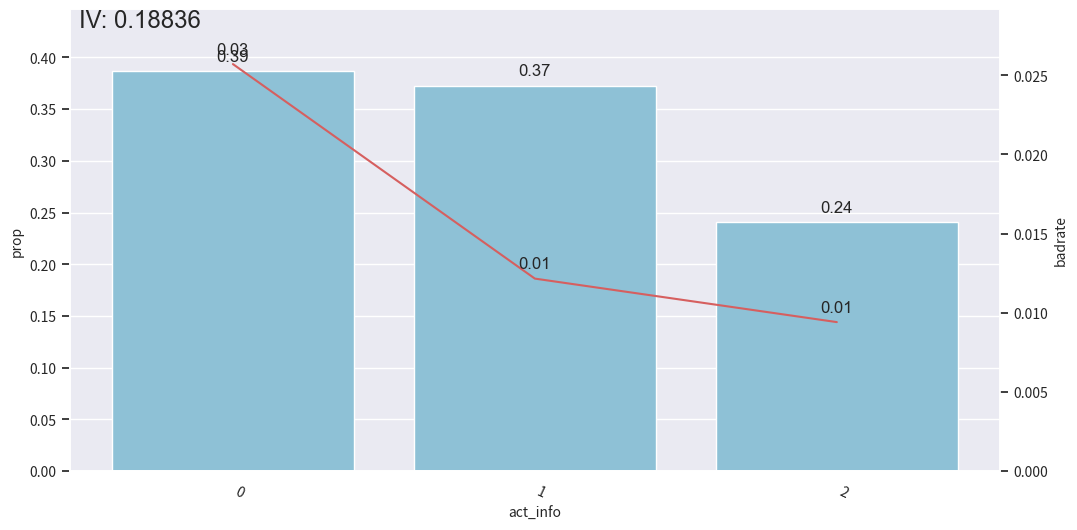

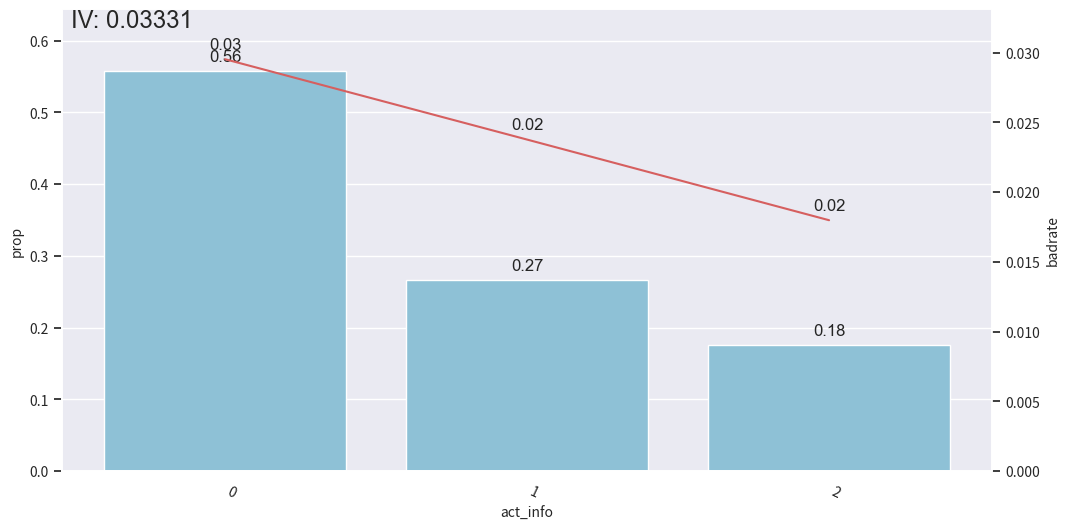

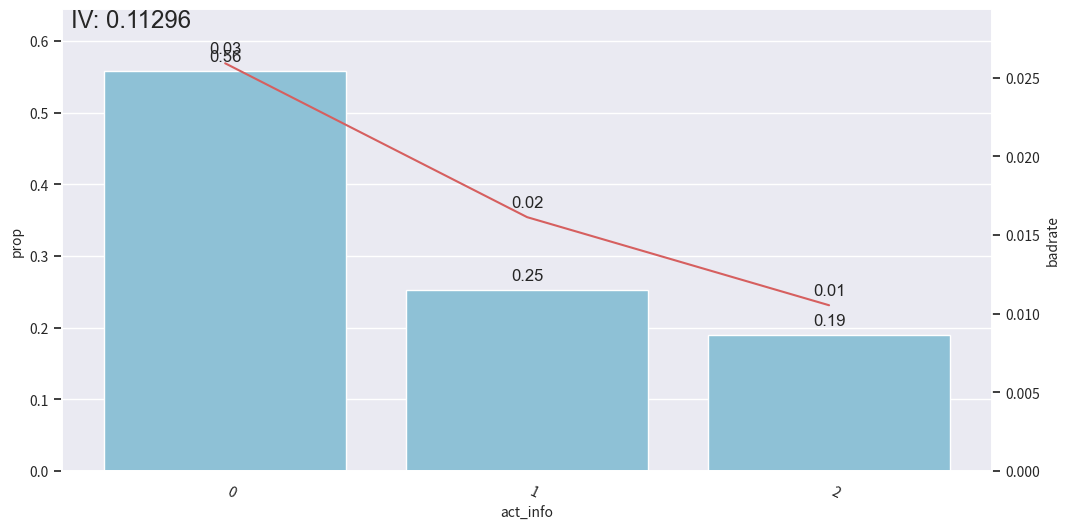

In [11]:
bin_plot(dev_slct3,x='act_info',target = 'bad_ind')
bin_plot(val3,x='act_info',target = 'bad_ind')
bin_plot(off3,x='act_info',target = 'bad_ind')

<Axes: xlabel='samp_type', ylabel='badrate'>

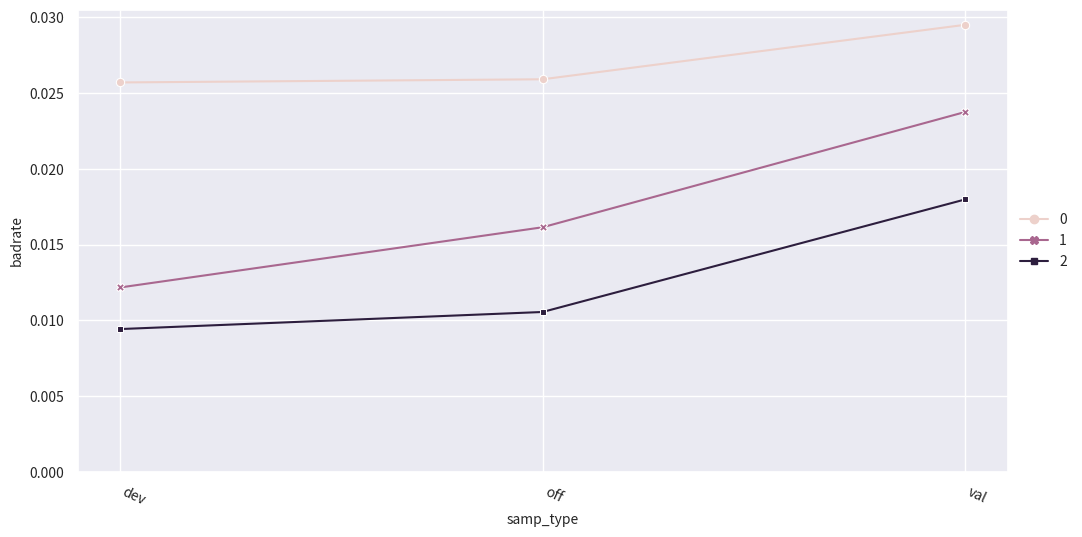

In [12]:
data=pd.concat([dev_slct3,val3,off3],join='inner')
badrate_plot(data,x='samp_type',target='bad_ind',by='act_info')

In [13]:
#woe变换
t=toad.transform.WOETransformer()
dev_slct3_woe=t.fit_transform(dev_slct3,dev_slct3['bad_ind'],exclude=ex_lis)#dev_woe is translated by woe based on dev3 model
val_woe=t.transform(val3[dev_slct3.columns])#val_woe is translated by woe 
off_woe=t.transform(off3[dev_slct3.columns])
data=pd.concat([dev_slct3_woe,val_woe,off_woe])

In [14]:
psi_df=toad.metrics.PSI(dev_slct3_woe,val_woe).sort_values(ascending=True)#psi data is the result through psi model 
psi_df = psi_df.reset_index()
psi_df = psi_df.rename(columns = {'index': 'feature', 0: 'psi'})
psi_df

,feature,psi
0,uid,0.000000e+00
1,samp_type,0.000000e+00
2,td_score,8.778656e-07
3,zcx_score,4.183912e-06
4,jxl_score,2.901553e-05
5,zzc_score,3.764148e-05
6,mj_score,5.005908e-05
7,bad_ind,4.128345e-03
8,credit_info,9.489392e-02
9,act_info,1.182993e-01


In [15]:
psi_013=list(psi_df[psi_df.psi<0.13].feature)#only want psi value less than 0.13
psi_013.extend(ex_lis)#put ex_lis back
psi_013=list(set(psi_013))
psi_013

['td_score',
 'act_info',
 'samp_type',
 'zzc_score',
 'person_info',
 'zcx_score',
 'mj_score',
 'bad_ind',
 'jxl_score',
 'uid',
 'credit_info']

In [16]:
data=data[psi_013]#So, only the variable columns in 'data' that have been filtered through PSI are needed
dev_woe_psi = dev_slct3_woe[psi_013]#dev_psi is constructed from dev_woe after PSI filtering
val_woe_psi = val_woe[psi_013]
off_woe_psi = off_woe[psi_013]

In [17]:
dev_woe_psi2, drop_lst = toad.selection.select(dev_woe_psi,
                                               dev_woe_psi['bad_ind'],
                                               empty=0.6,
                                               iv=0.001,
                                               corr=0.5,
                                               return_drop=True,
                                               exclude=ex_lis)
#dev_psi2 here is dev_psi after IV filtering
print("keep:", dev_woe_psi2.shape[1],
      "drop empty:", len(drop_lst['empty']),
      "drop iv:", len(drop_lst['iv']),
      "drop corr:", len(drop_lst['corr']))

keep: 7 drop empty: 0 drop iv: 4 drop corr: 0


In [18]:
dev_woe_psi_stp = toad.selection.stepwise(dev_woe_psi2,
                                                  dev_woe_psi2['bad_ind'],
                                                  exclude=ex_lis,
                                                  direction='both',
                                                  criterion='ks',
                                                  estimator='ols',
                                              intercept=False)
#dev_psi_stp is derived from dev_psi2 through some form of filtering

In [19]:
val_woe_psi_stp = val_woe_psi[dev_woe_psi_stp.columns]
#val_psi_stp用相同方式从val_psi筛选出来的
off_woe_psi_stp = off_woe_psi[dev_woe_psi_stp.columns]
data = pd.concat([dev_woe_psi_stp, val_woe_psi_stp, off_woe_psi_stp])
print(data.shape)

(95806, 6)


In [20]:
def lr_model(x,y,valx,valy,offx,offy,C):
    model=LogisticRegression(C=C,class_weight='balanced')
    model.fit(x,y)

    y_pred=model.predict_proba(x)[:,1]
    fpr_dev,tpr_dev,_=roc_curve(y,y_pred)
    train_ks=abs(fpr_dev-tpr_dev).max()
    print('train_ks:',train_ks)

    y_pred=model.predict_proba(valx)[:,1]
    fpr_val,tpr_val,_=roc_curve(valy,y_pred)
    val_ks=abs(fpr_val-tpr_val).max()
    print('val_ks:',val_ks)

    y_pred=model.predict_proba(offx)[:,1]
    fpr_off,tpr_off,_=roc_curve(offy,y_pred)#主要是看这仨的FPR,TPR图的
    off_ks=abs(fpr_off-tpr_off).max()
    print('off_ks:',off_ks)

    from matplotlib import pyplot as plt
    plt.plot(fpr_dev, tpr_dev, label='dev')
    plt.plot(fpr_val, tpr_val, label='val')
    plt.plot(fpr_off, tpr_off, label='off')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

In [21]:
#同理，只是model不是逻辑回归了，而是XGB
def xgb_model(x, y, valx, valy, offx, offy):
    model = xgb.XGBClassifier(learning_rate=0.05,
                                  n_estimators=400,
                                  max_depth=2,
                                  class_weight='balanced',
                                  min_child_weight=1,
                                  subsample=1,
                                  nthread=-1,
                                  scale_pos_weight=1,
                                  random_state=1,
                                  n_jobs=-1,
                                  reg_lambda=300)
    model.fit(x, y)

    y_pred = model.predict_proba(x)[:, 1]
    fpr_dev, tpr_dev, _ = roc_curve(y, y_pred)
    train_ks = abs(fpr_dev - tpr_dev).max()
    print('train_ks : ', train_ks)

    y_pred = model.predict_proba(valx)[:, 1]
    fpr_val, tpr_val, _ = roc_curve(valy, y_pred)
    val_ks = abs(fpr_val - tpr_val).max()
    print('val_ks : ', val_ks)

    y_pred = model.predict_proba(offx)[:, 1]
    fpr_off, tpr_off, _ = roc_curve(offy, y_pred)
    off_ks = abs(fpr_off - tpr_off).max()
    print('off_ks : ', off_ks)

    from matplotlib import pyplot as plt
    plt.plot(fpr_dev, tpr_dev, label='dev')
    plt.plot(fpr_val, tpr_val, label='val')
    plt.plot(fpr_off, tpr_off, label='off')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

In [22]:
def bi_train(data,dep='bad_ind',exclude=None):
    #正则化函数
    from sklearn.preprocessing import StandardScaler
    std_scaler=StandardScaler()

    lis=list(data.columns)
    for i in exclude:
        lis.remove(i)
    data[lis]=std_scaler.fit_transform(data[lis])
    devv=data[(data['samp_type']=='dev')]
    vall=data[(data['samp_type']=='val')]
    offf=data[(data['samp_type']=='off')]
    x,y=devv[lis],devv[dep]
    valx,valy=vall[lis],vall[dep]
    offx,offy=offf[lis],offf[dep]

        # 逻辑回归正向
    print("逻辑回归正向：")
    print(lr_model(x, y, valx, valy, offx, offy, 0.1))
        # 逻辑回归反向
    print("逻辑回归反向：")
    print(lr_model(offx, offy, valx, valy, x, y, 0.1))
        # XGBoost正向
    print("XGBoost正向：")
    print(xgb_model(x, y, valx, valy, offx, offy))
        # XGBoost反向
    print("XGBoost反向：")
    print(xgb_model(offx, offy, valx, valy, x, y))

逻辑回归正向：
train_ks: 0.4175617517173731
val_ks: 0.3588328912466844
off_ks: 0.36930421478753034


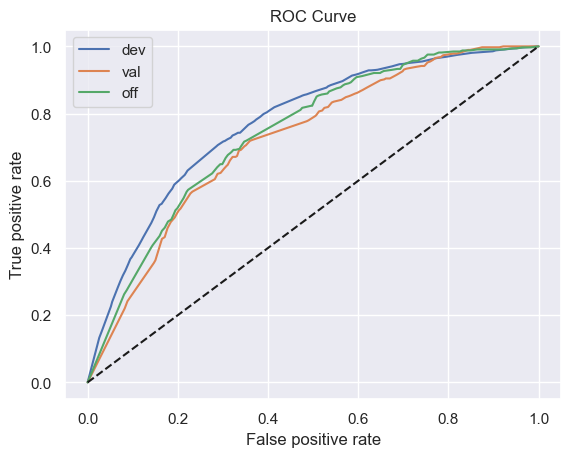

None
逻辑回归反向：
train_ks: 0.38527996483390414
val_ks: 0.37396631393463364
off_ks: 0.40858234950836764


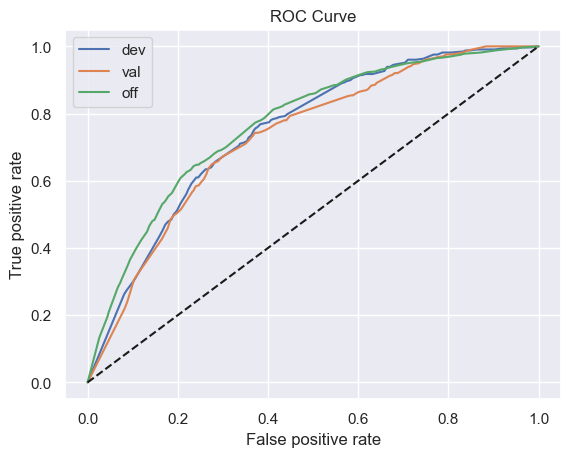

None
XGBoost正向：
[14:03:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "class_weight" } are not used.

train_ks :  0.4237042266146137
val_ks :  0.3595635995538518
off_ks :  0.37518296190183736


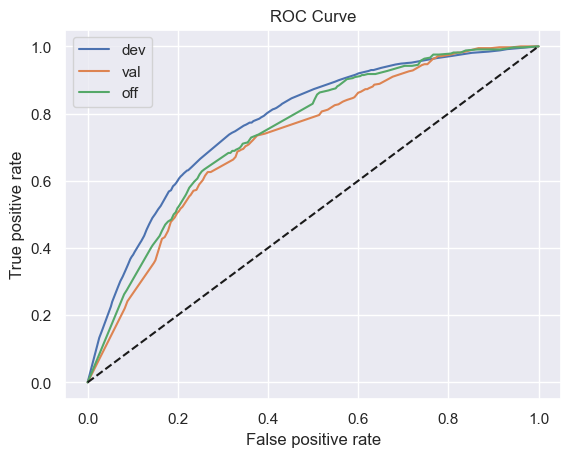

None
XGBoost反向：
[14:03:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "class_weight" } are not used.

train_ks :  0.3938834608675862
val_ks :  0.37747626322745126
off_ks :  0.39338531134694127


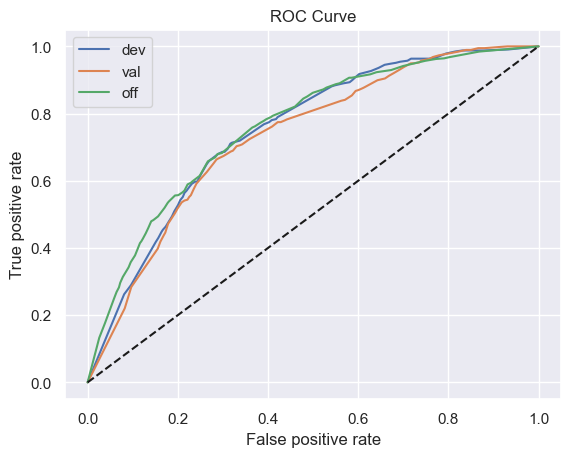

None


In [26]:
bi_train(data,dep='bad_ind',exclude=ex_lis)

dep='bad_ind'
lis=list(data.columns)

In [27]:
for i in ex_lis:
    lis.remove(i)
devv=data[data['samp_type']=='dev']
vall=data[data['samp_type']=='val']
offf=data[data['samp_type']=='off']
x,y=devv[lis],devv[dep]
valx,valy=vall[lis],vall[dep]
offx,offy=offf[lis],offf[dep]
lr=LogisticRegression()
lr.fit(x,y)

LogisticRegression()

In [28]:
from toad.metrics import KS,F1,AUC
prob_dev = lr.predict_proba(x)[:,1]
print('训练集')
print('F1:', F1(prob_dev,y))
print('KS:', KS(prob_dev,y))
print('AUC:', AUC(prob_dev,y))

训练集
F1: 0.029351208260445533
KS: 0.4175617517173731
AUC: 0.7721143736676812


In [29]:
prob_val = lr.predict_proba(valx)[:,1]
print('验证集')
print('F1:', F1(prob_val,valy))
print('KS:', KS(prob_val,valy))
print('AUC:', AUC(prob_val,valy))

验证集
F1: 0.03797468354430379
KS: 0.3588328912466844
AUC: 0.7222256797668032


In [30]:
prob_off = lr.predict_proba(offx)[:,1]
print('跨时间')
print('F1:', F1(prob_off,offy))
print('KS:', KS(prob_off,offy))
print('AUC:', AUC(prob_off,offy))

跨时间
F1: 0.022392178506662464
KS: 0.3696948842371405
AUC: 0.7436315034285385


In [31]:
print('模型PSI:',toad.metrics.PSI(prob_dev,prob_off))
print('特征PSI:','\n',toad.metrics.PSI(x,offx).sort_values(0))

模型PSI: 0.33682698167332736
特征PSI: 
 credit_info    0.098585
act_info       0.122049
person_info    0.127833
dtype: float64


C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_12896\3655590338.py:2: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  print('特征PSI:','\n',toad.metrics.PSI(x,offx).sort_values(0))


In [32]:
toad.metrics.KS_bucket(prob_off,offy,bucket=15,method='quantile')


,min,max,bads,goods,total,bad_rate,good_rate,odds,bad_prop,good_prop,...,cum_bad_rate_rev,cum_bads_prop,cum_bads_prop_rev,cum_goods_prop,cum_goods_prop_rev,cum_total_prop,cum_total_prop_rev,ks,lift,cum_lift
0,0.001873,0.003195,2.0,922.0,924.0,0.002165,0.997835,0.002169,0.006098,0.058925,...,0.020532,0.006098,1.000000,0.058925,1.000000,0.057840,1.000000,0.052827,0.105420,1.000000
1,0.003623,0.004079,1.0,1053.0,1054.0,0.000949,0.999051,0.000950,0.003049,0.067297,...,0.021660,0.009146,0.993902,0.126222,0.941075,0.123818,0.942160,0.117076,0.046209,1.054919
2,0.004275,0.006219,2.0,976.0,978.0,0.002045,0.997955,0.002049,0.006098,0.062376,...,0.023219,0.015244,0.990854,0.188598,0.873778,0.185039,0.876182,0.173355,0.099600,1.130877
3,0.006260,0.008334,7.0,1282.0,1289.0,0.005431,0.994569,0.005460,0.021341,0.081933,...,0.024810,0.036585,0.984756,0.270531,0.811402,0.265728,0.814961,0.233946,0.264492,1.208348
4,0.008360,0.008793,11.0,875.0,886.0,0.012415,0.987585,0.012571,0.033537,0.055921,...,0.026939,0.070122,0.963415,0.326452,0.729469,0.321189,0.734272,0.256330,0.604681,1.312067
5,0.008883,0.010726,7.0,1206.0,1213.0,0.005771,0.994229,0.005804,0.021341,0.077075,...,0.028126,0.091463,0.929878,0.403528,0.673548,0.397121,0.678811,0.312064,0.281063,1.369864
6,0.011772,0.014396,14.0,953.0,967.0,0.014478,0.985522,0.014690,0.042683,0.060906,...,0.030942,0.134146,0.908537,0.464434,0.596472,0.457653,0.602879,0.330288,0.705129,1.506995
7,0.014871,0.018114,16.0,934.0,950.0,0.016842,0.983158,0.017131,0.048780,0.059692,...,0.032779,0.182927,0.865854,0.524126,0.535566,0.517121,0.542347,0.341199,0.820282,1.596493
8,0.018115,0.021889,41.0,2307.0,2348.0,0.017462,0.982538,0.017772,0.125000,0.147440,...,0.034742,0.307927,0.817073,0.671566,0.475874,0.664100,0.482879,0.363640,0.850458,1.692085
9,0.022342,0.030438,20.0,730.0,750.0,0.026667,0.973333,0.027397,0.060976,0.046654,...,0.042303,0.368902,0.692073,0.718221,0.328434,0.711049,0.335900,0.349318,1.298780,2.060356


In [33]:
from toad.scorecard import ScoreCard
card = ScoreCard(combiner=combiner,
                    transer=t, C=0.1,
                    class_weight='balanced',
                    base_score=600,
                    base_odds=35,
                    pdo=60,
                    rate=2)
card.fit(x,y)
final_card = card.export(to_frame=True)
print(final_card)
print(card.predict(x))

           name                                        value   score
0      act_info                 [-inf ~ 0.16666666666666666)   94.95
1      act_info  [0.16666666666666666 ~ 0.35897435897435903)  117.49
2      act_info                  [0.35897435897435903 ~ inf)  125.15
3   person_info                 [-inf ~ -0.2610139784946237)  172.88
4   person_info  [-0.2610139784946237 ~ -0.1286774193548387)  143.01
5   person_info  [-0.1286774193548387 ~ -0.0537175627240143)  123.80
6   person_info    [-0.0537175627240143 ~ 0.013863440860215)  120.84
7   person_info     [0.013863440860215 ~ 0.0626602150537634)  108.88
8   person_info     [0.0626602150537634 ~ 0.078853046594982)   90.34
9   person_info                    [0.078853046594982 ~ inf)   75.46
10  credit_info                                [-inf ~ 0.02)  158.16
11  credit_info                                [0.02 ~ 0.04)  122.58
12  credit_info                                [0.04 ~ 0.11)   73.93
13  credit_info                   